In [12]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import font_manager, rc
import warnings

warnings.filterwarnings(action='ignore')

In [3]:
# 폰트 사이즈
plt.rcParams['font.size'] = 25
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# figsize
plt.rcParams['figure.figsize'] = (16,18)

In [123]:
# 함수

# 특수기호 제거
def text_prepro(text):
    text = str(text)
    words = text.split(' ')
    
    prepro_words = []
    for word in words:
        prepro_word = re.sub(r'[^가-힣]' ,' ',word)
        prepro_words.append(prepro_word)
    
    result = ' '.join(prepro_words)
    return result

# tolkenizing
def tokenize(text):
    okt = Okt()
    tokens = okt.pos(text)
    
    token_words = []
    for word,tag in tokens:
        if tag not in ['Josa', 'Suffix']:
            token_words.append(word)
    
    result = ' '.join(token_words)
    return result

# 빈도분석 통해 얻은 단어와 빈도수
def count_vector(data, vectorizer):
    word_dict = sorted(vectorizer.vocabulary_.items())
    idx2word = {idx:word for word, idx in word_dict}
    
    total_word = []
    total_word.append(' '.join(data.values))
    
    count_matrix = vectorizer.transform(total_word)
    
    count_word = []
    count_vector = []
    
    for i in range(20,0,-1):
        count_word.append(idx2word[(-count_matrix.toarray()[0]).argsort()[i-1]])
        count_vector.append(count_matrix.toarray()[0][(-count_matrix.toarray()[0]).argsort()[i-1]])
    
    return count_word, count_vector

def count_graph(word, vector, color, title):
    plt.barh(word, vector, label='단어 빈도', color=color)
    plt.legend()
#     plt.xlabel('빈도')
#     plt.ylabel('단어')
    plt.yticks(word)
    plt.title('{} 텍스트 빈도 분석 Top20'.format(title))
    
    # 그래프 수치 표시
#     for idx, val in enumerate(word):
#         plt.text(vector[idx], val, vector[idx], color='#000000',
#                  horizontalalignment='right', verticalalignment='center')
    plt.savefig('{}.png'.format(title))
    plt.show()
    

In [ ]:
# 도메인 설명
# 성별 - 남(1), 여(2)
# 연령대 - 10대(1), 20대(2), 30대(3), 40대(4), 50대 이상(5)
# 지역 - 수도권(1,4,8) & 비수도권(그 외 나머지)
# 직업 - 직장인(1), 학생(2), 주부(3), 기타(4)(무직, 요양, 자영업, 취직준비생, 퇴직, 프리랜서)
# 결혼여부 - 미혼(1), 기혼(2), 기타(3)(별거, 이혼)
# 가구구성 - 1인가구(1), 2인가구(2), 3인가구(3), 4인가구(4), 5인가구이상(5)

In [5]:
path = './배달 관련 조사_Raw data.xlsx'
df = pd.read_excel(path, sheet_name=0)

# 사용할 데이터
use_df = df[['SQ1', 'HQ_AGE', 'SQ3', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6t1']]
use_df.columns = ['성별', '연령대', '지역', '직업', '결혼여부', '가구구성', '최종학력', '배달비의견']

In [8]:
use_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   성별      366 non-null    int64  
 1   연령대     366 non-null    int64  
 2   지역      366 non-null    int64  
 3   직업      328 non-null    float64
 4   결혼여부    328 non-null    float64
 5   가구구성    328 non-null    float64
 6   최종학력    328 non-null    float64
 7   배달비의견   328 non-null    object 
dtypes: float64(4), int64(3), object(1)
memory usage: 23.0+ KB


In [171]:
# 결측치 제거
use_df.dropna(how='any', axis=0, inplace=True)

# 전체 데이터 특수기호 제거 및 tokenizing
use_df['배달비의견'] = use_df['배달비의견'].map(text_prepro).map(tokenize)
use_df

# 비싸요 & 비싼을 비싸다로 바꾸기
use_df['배달비의견'] = use_df['배달비의견'].map(lambda x : x.replace('비싼', '비싸다'))
use_df['배달비의견'] = use_df['배달비의견'].map(lambda x : x.replace('비싸요', '비싸다'))
use_df['배달비의견'] = use_df['배달비의견'].map(lambda x : x.replace('부담스러워요', '부담스럽다'))

In [172]:
# 지역 구분
# 수도권 (125개)
sudo = use_df['배달비의견'][use_df['지역'].isin([1,4,8])]
# 비수도권 (203개)
non_sudo = use_df['배달비의견'][~(use_df['지역'].isin([1,4,8]))]

##########################################################

# 직업구분
# 직장인 (170개)
office = use_df['배달비의견'][use_df['직업']==1.0]
# 학생 (90개)
student = use_df['배달비의견'][use_df['직업']==2.0]
# 주부 (48개)
home = use_df['배달비의견'][use_df['직업']==3.0]
# 기타 (20개)
etc_job = use_df['배달비의견'][use_df['직업']==4.0]

##########################################################

# 결혼여부
# 미혼, 이혼, 별겨 (173개)
no_marry = use_df['배달비의견'][use_df['결혼여부'].isin([1.0, 3.0])]
# 기혼 (155개)
marry = use_df['배달비의견'][use_df['결혼여부']==2.0]

##########################################################

# 가구 구성원
# 1인 가구 (31개)
family1 = use_df['배달비의견'][use_df['가구구성']==1.0]
# 2인 가구 (56개)
family2 = use_df['배달비의견'][use_df['가구구성']==2.0]
# 3인 가구 (87개)
family3 = use_df['배달비의견'][use_df['가구구성']==3.0]
# 4인 가구 (117개)
family4 = use_df['배달비의견'][use_df['가구구성']==4.0]
# 5인 가구 (37개)
family5 = use_df['배달비의견'][use_df['가구구성']==5.0]

In [232]:
# 불용어 사전
stop_words = ['부담', '한다', '너무', '합니다', '생각', '한다고', '소비자', 
              '정도', '하는', '같다', '하면', '비는', '배달', '하지만', '해야', 
              '어느', '경우', '때문', '있다', '없음', '하는데', '하는건', '있지만', '많은',
              '있습니다', '있어서', '부분', '당연히', '어쩔', '같습니다', '없다', '시켜',
              '야한다고', '위해', '좋겠습니다', '따로', '좋겠어요', '좋겠다', '된다', '않았으면', 
              '했으면', '곳도', '맞다고', '하는게','조금', '있는데', '없다고', '요즘', '원인',
              '같아요', '하지', '받지', '됩니다', '비싸다는', '비해', '그건', '된다고', '좋겠음',
              '만큼', '않는', '비싸다고', '또한', '매우', '없는', '내야', '음식', '좋지', '되요',
              '좋을것', '되면', '되어야', '되는', '맞지만', '않아', '봅니다', '약간', '하다고',
              '더욱', '나쁘지', '하는것은', '하다', '해서', '있고', '기도', '아닌데', '해도',
              '바랍니다', '하겠으나', '되지만', '먹는게', '줬으면', '않다면', '구가', '그래도',
              '하나', '않다', '안되나요', '않고', '좀해', '이면', '업체', '하게', '이제', '이전',
              '예전', '아니나', '되는데', '사실', '좋']

# CountVectorizer
count_vec = CountVectorizer(max_features=200,
                            ngram_range=(1,1),
                            #max_df = 0.5,
                            stop_words=stop_words).fit(use_df['배달비의견'])

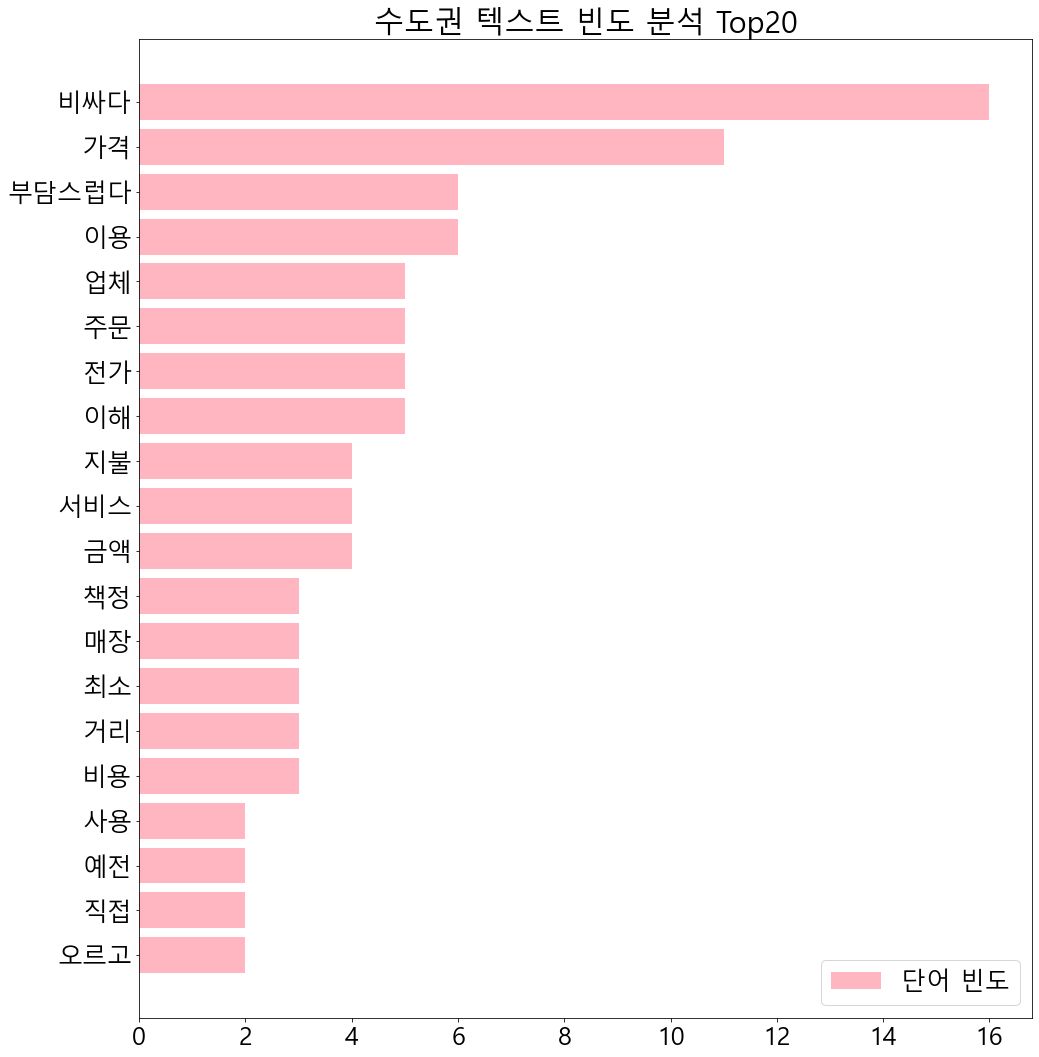

In [178]:
# 수도권
sudo_word, sudo_vector = count_vector(sudo, count_vec)
count_graph(sudo_word, sudo_vector,'lightpink', '수도권')

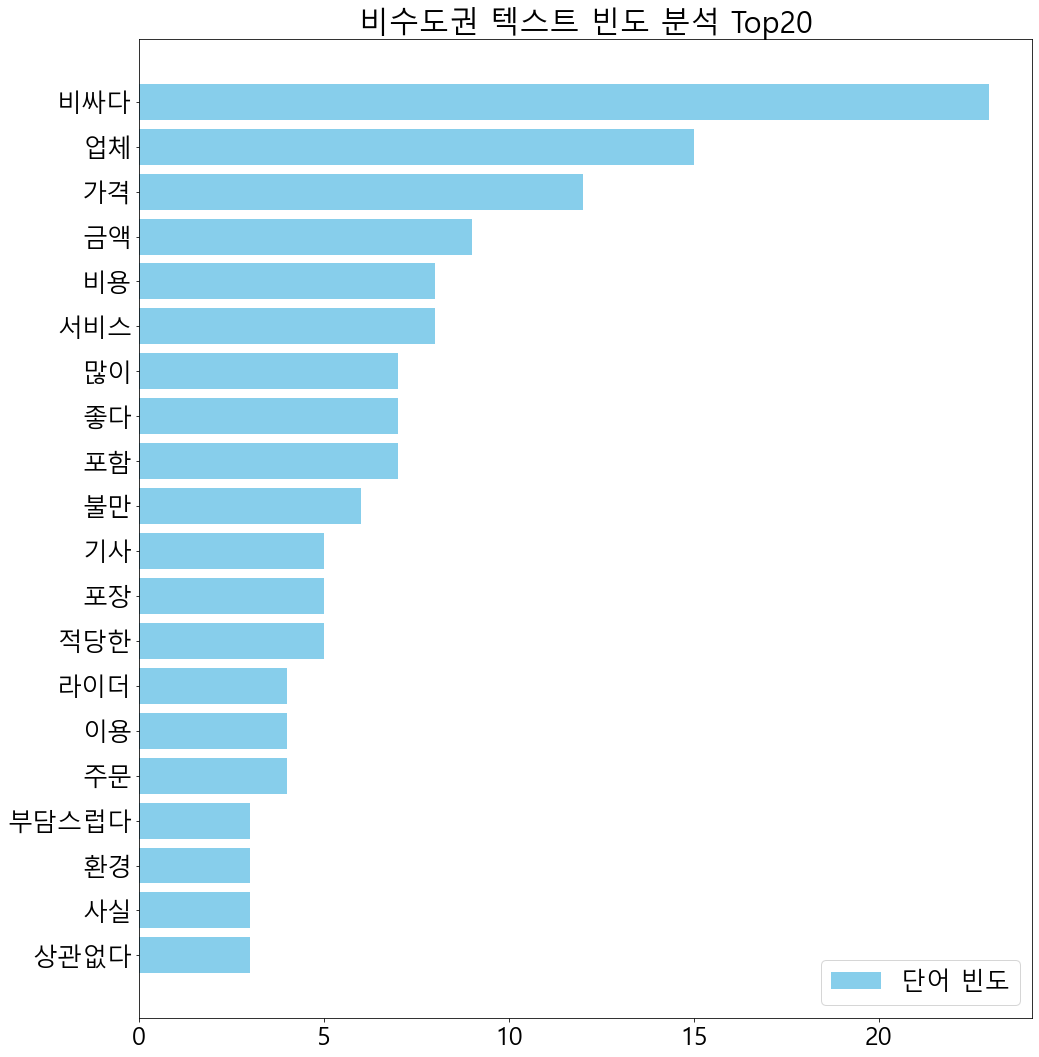

In [179]:
# 비수도권
non_sudo_word, non_sudo_vector = count_vector(non_sudo, count_vec)
count_graph(non_sudo_word, non_sudo_vector,'skyblue', '비수도권')

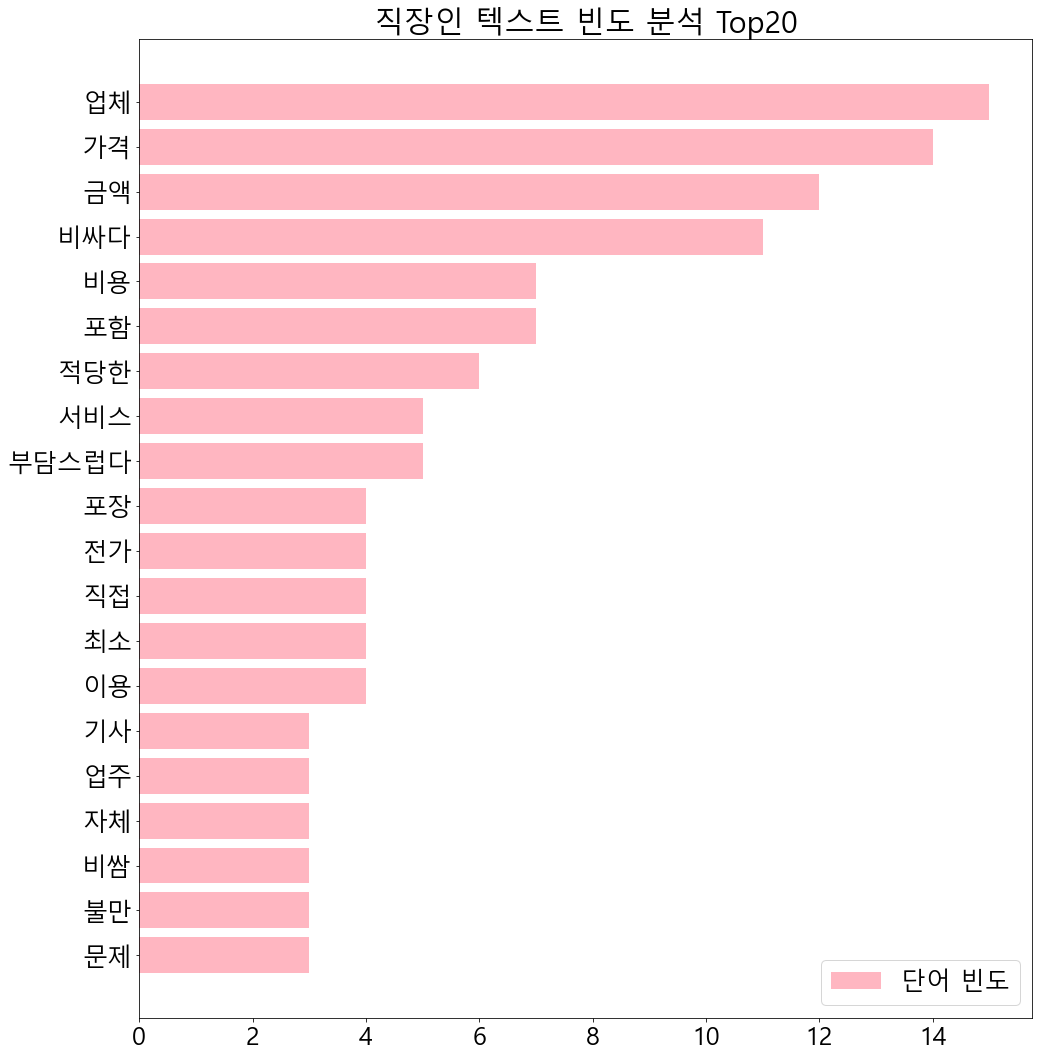

In [182]:
# 직장인
office_word, office_vector = count_vector(office, count_vec)
count_graph(office_word, office_vector,'lightpink', '직장인')

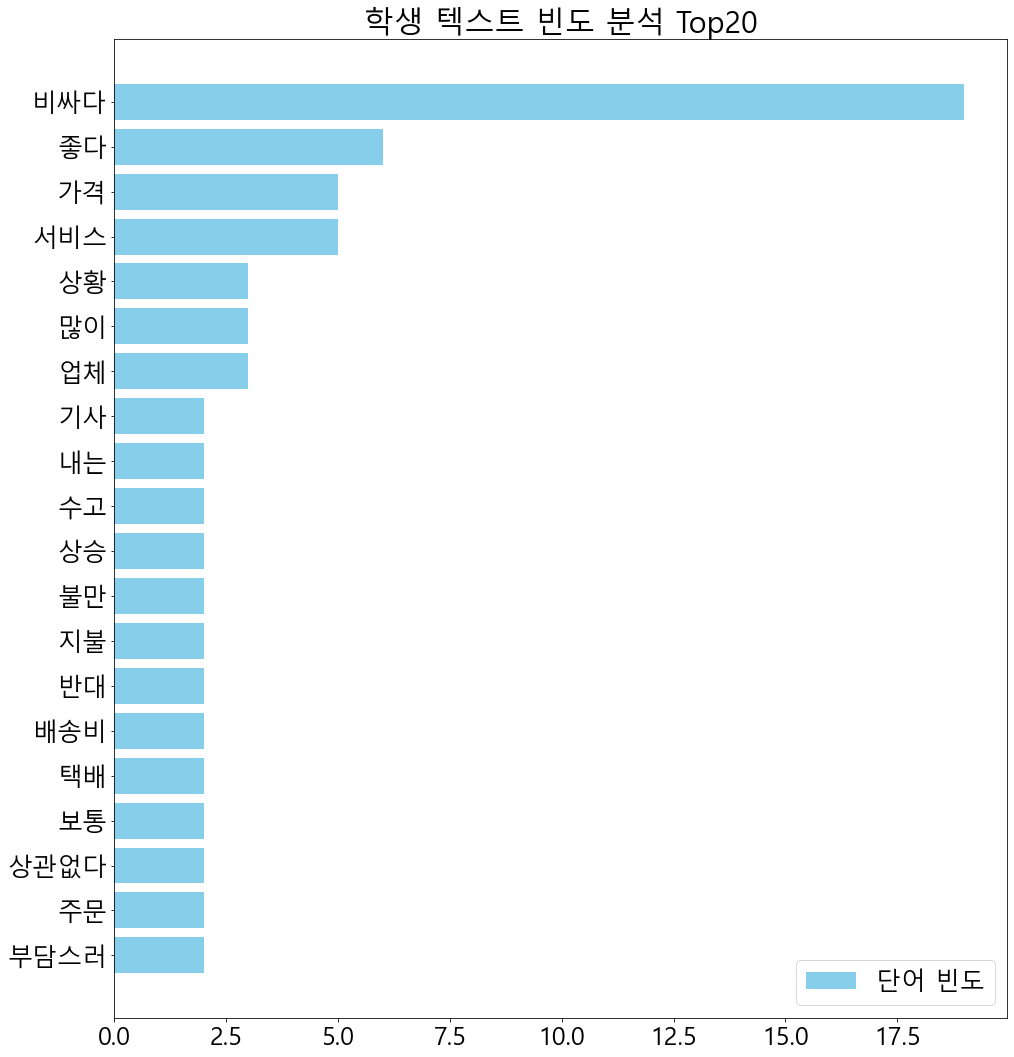

In [191]:
# 학생
student_word, student_vector = count_vector(student, count_vec)
count_graph(student_word, student_vector,'skyblue', '학생')

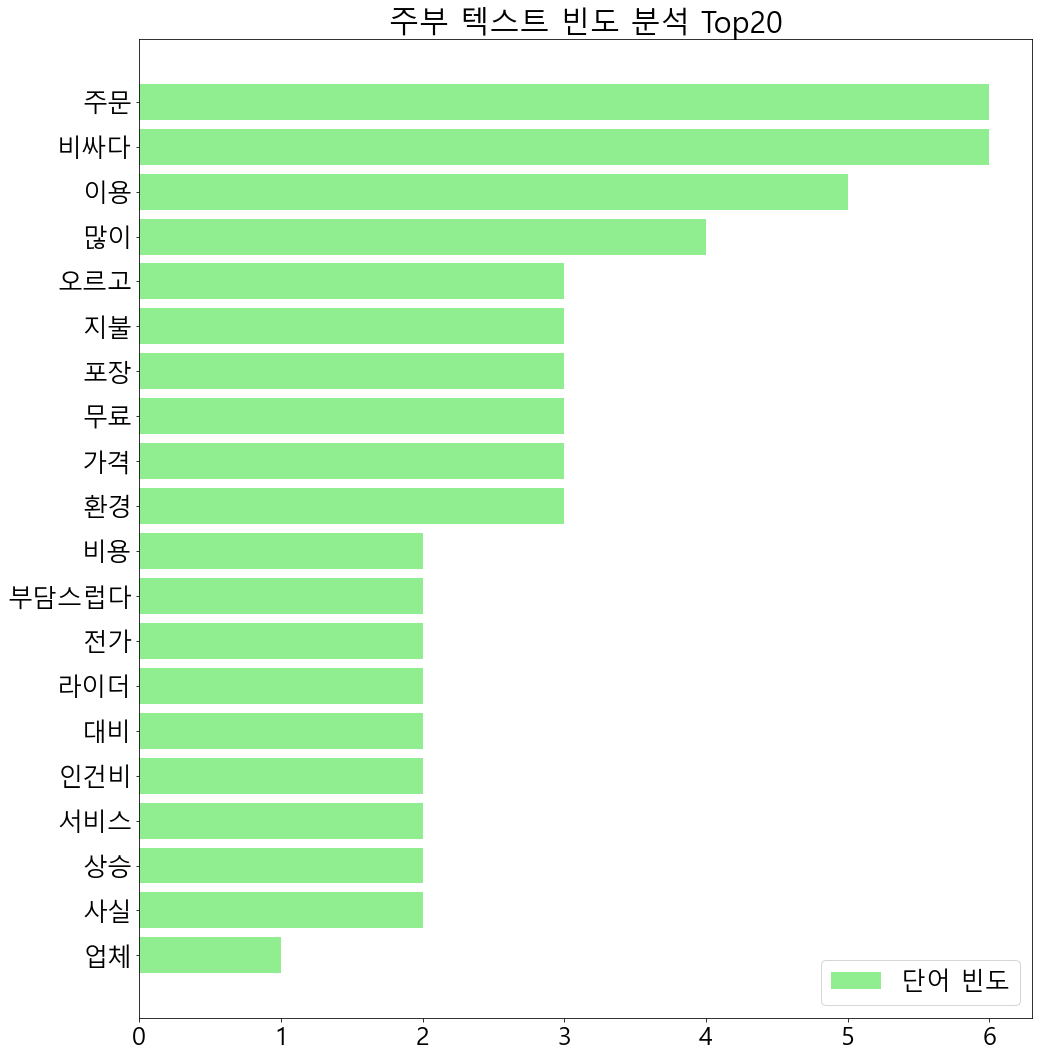

In [198]:
# 주부
home_word, home_vector = count_vector(home, count_vec)
count_graph(home_word, home_vector,'lightgreen', '주부')

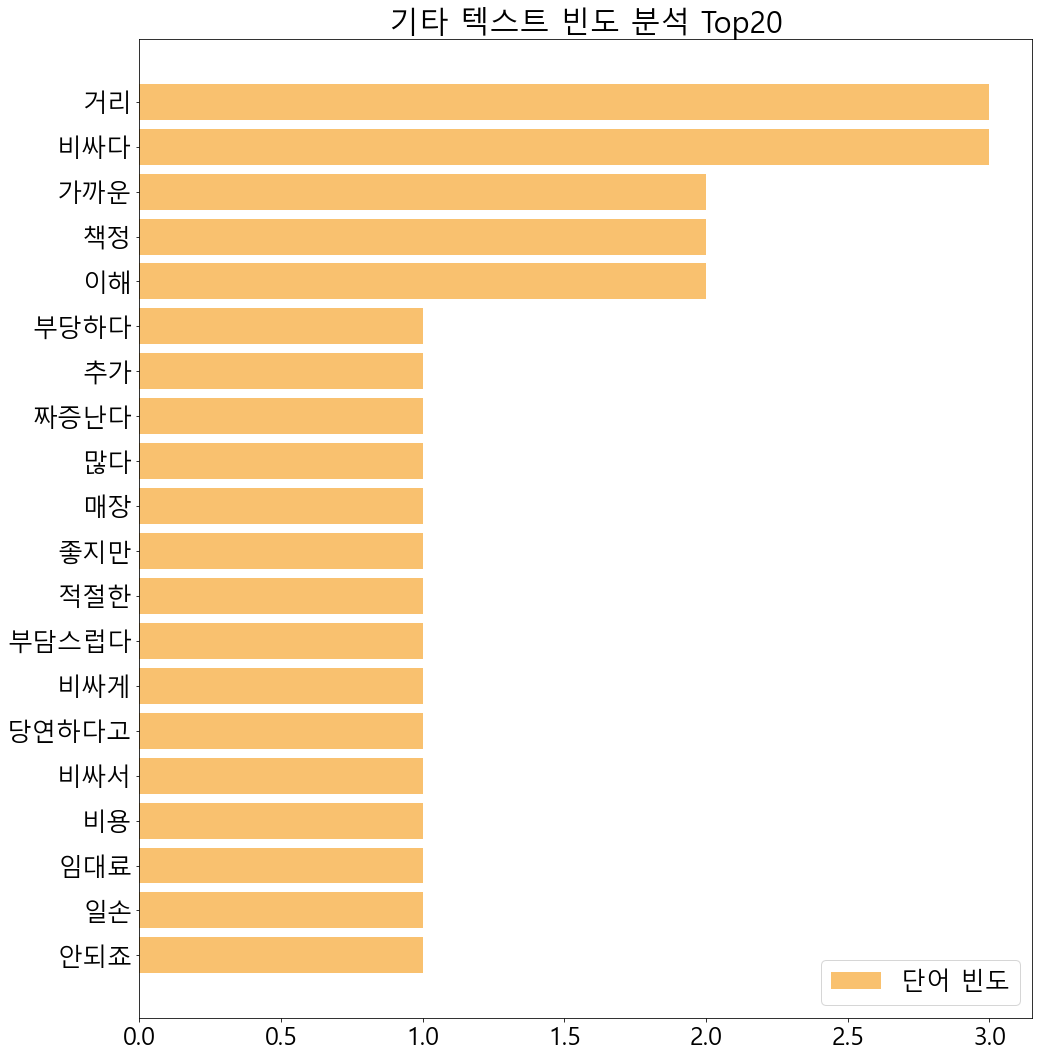

In [209]:
# 기타
etc_job_word, etc_job_vector = count_vector(etc_job, count_vec)
count_graph(etc_job_word, etc_job_vector,'#F9C16F', '기타')

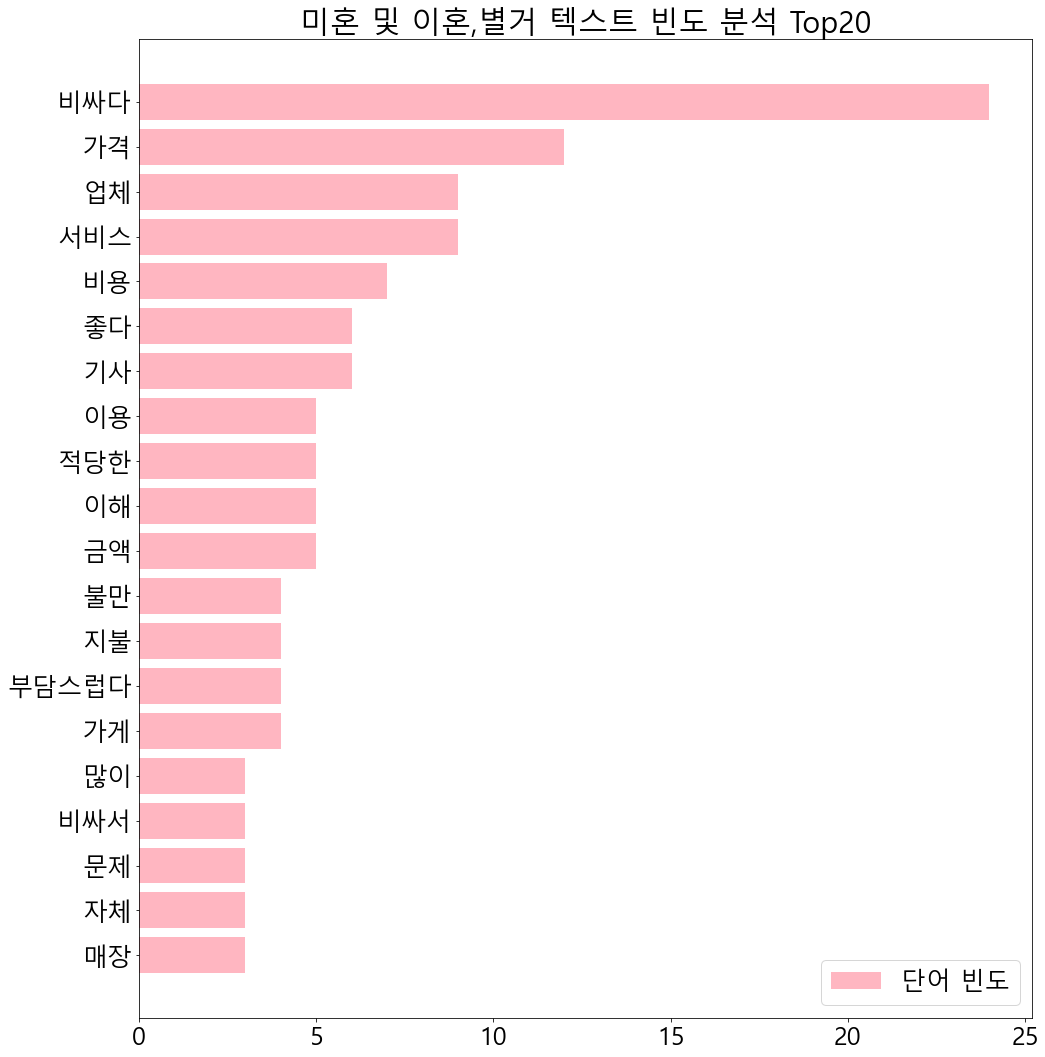

In [212]:
# 미혼 & 기타
no_marry_word, no_marry_vector = count_vector(no_marry, count_vec)
count_graph(no_marry_word, no_marry_vector,'lightpink', '미혼 및 이혼,별거')

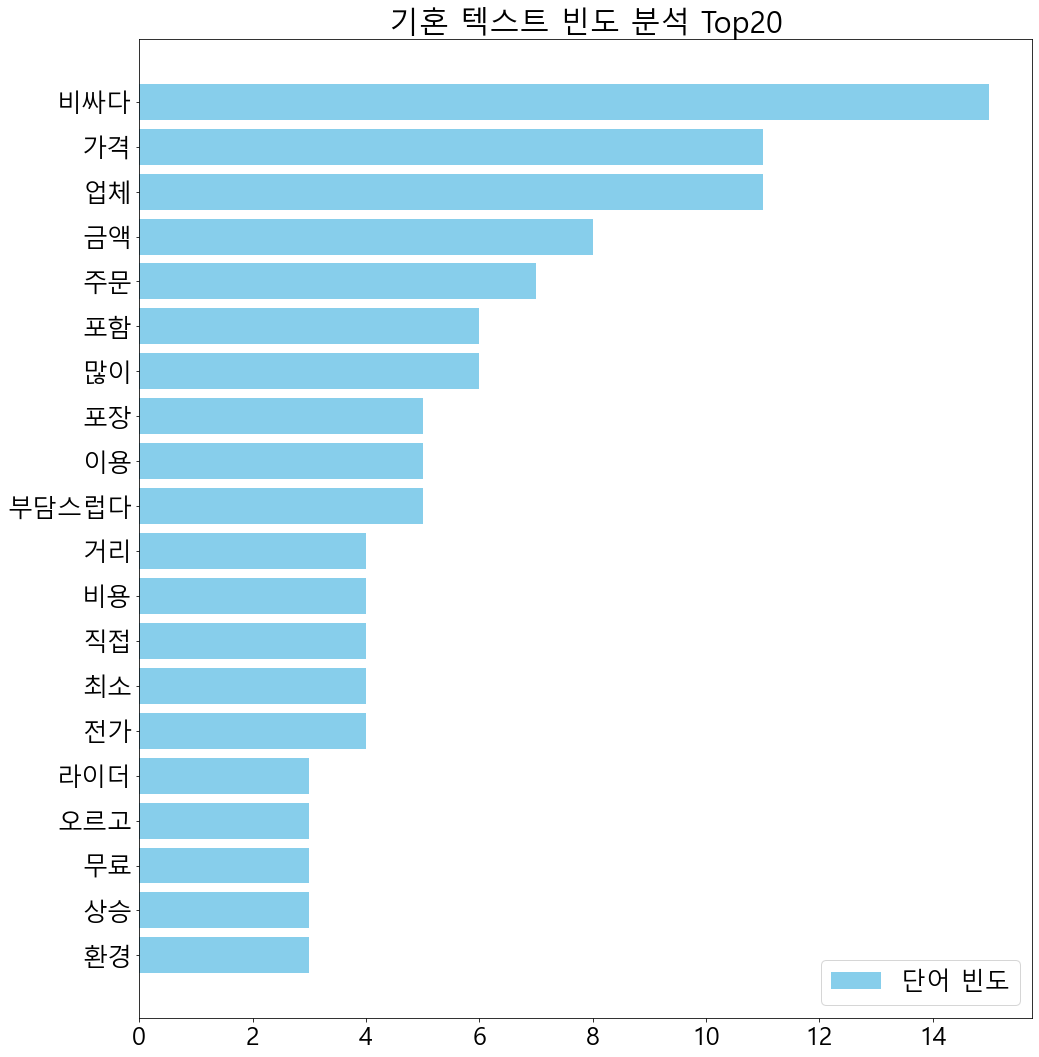

In [213]:
# 기혼
marry_word, marry_vector = count_vector(marry, count_vec)
count_graph(marry_word, marry_vector,'skyblue', '기혼')

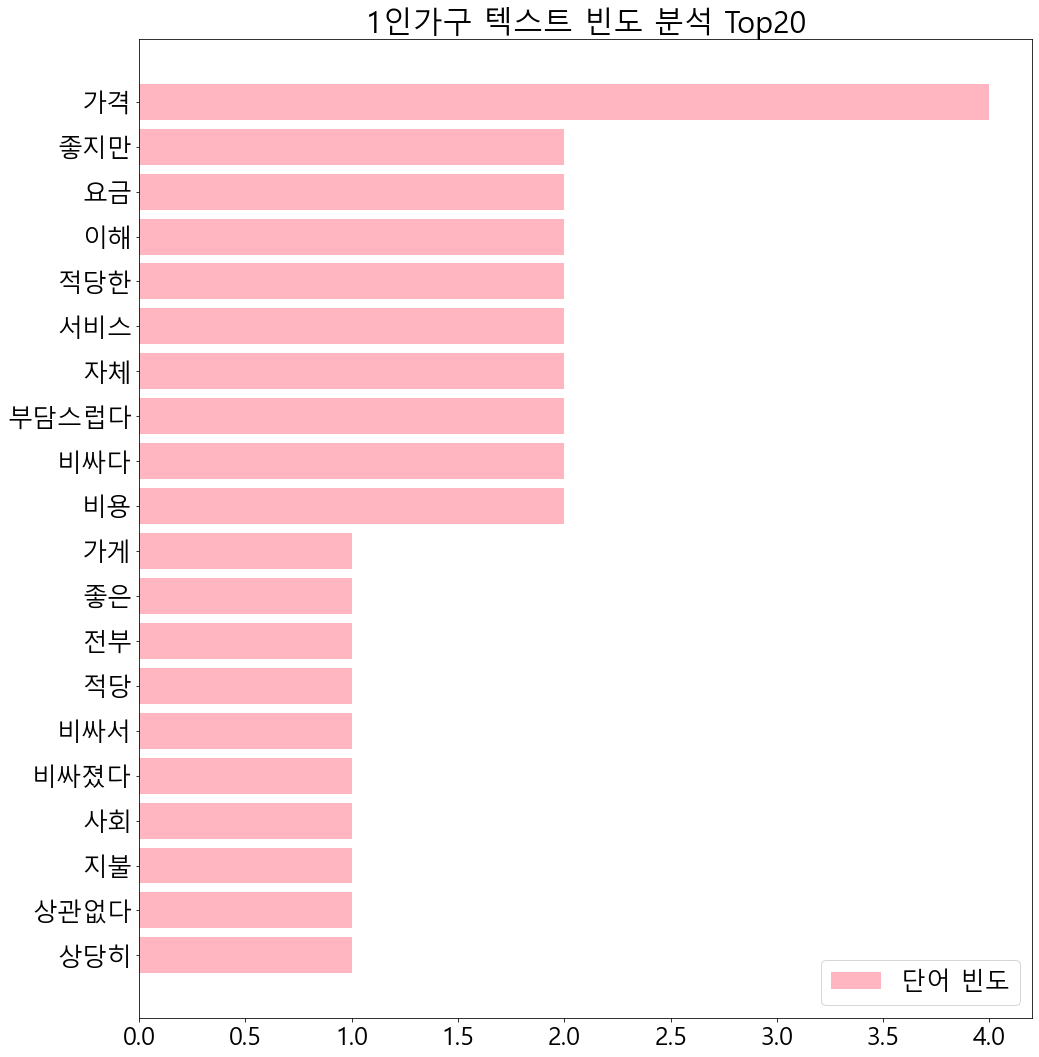

In [218]:
# 1인가구
family1_word, family1_vector = count_vector(family1, count_vec)
count_graph(family1_word, family1_vector,'lightpink', '1인가구')

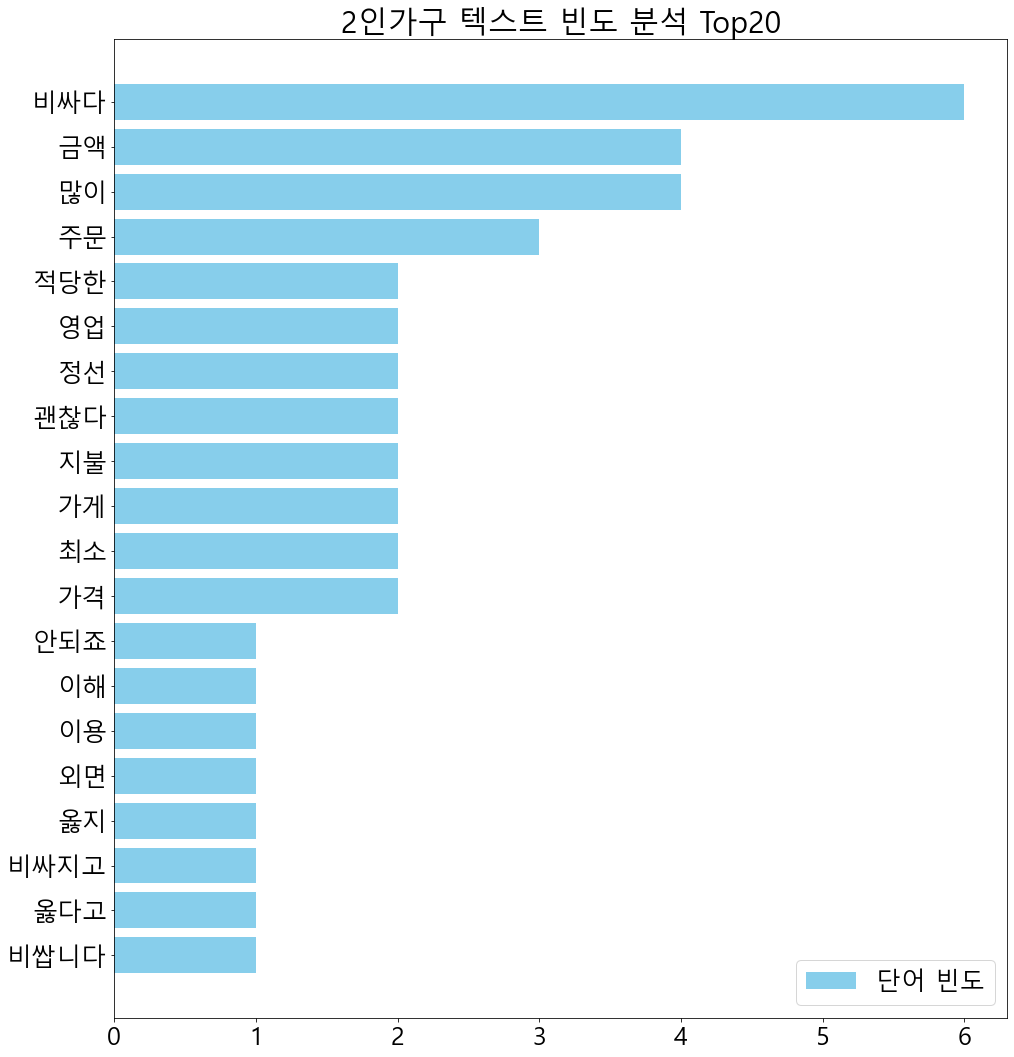

In [223]:
# 2인가구
family2_word, family2_vector = count_vector(family2, count_vec)
count_graph(family2_word, family2_vector,'skyblue', '2인가구')

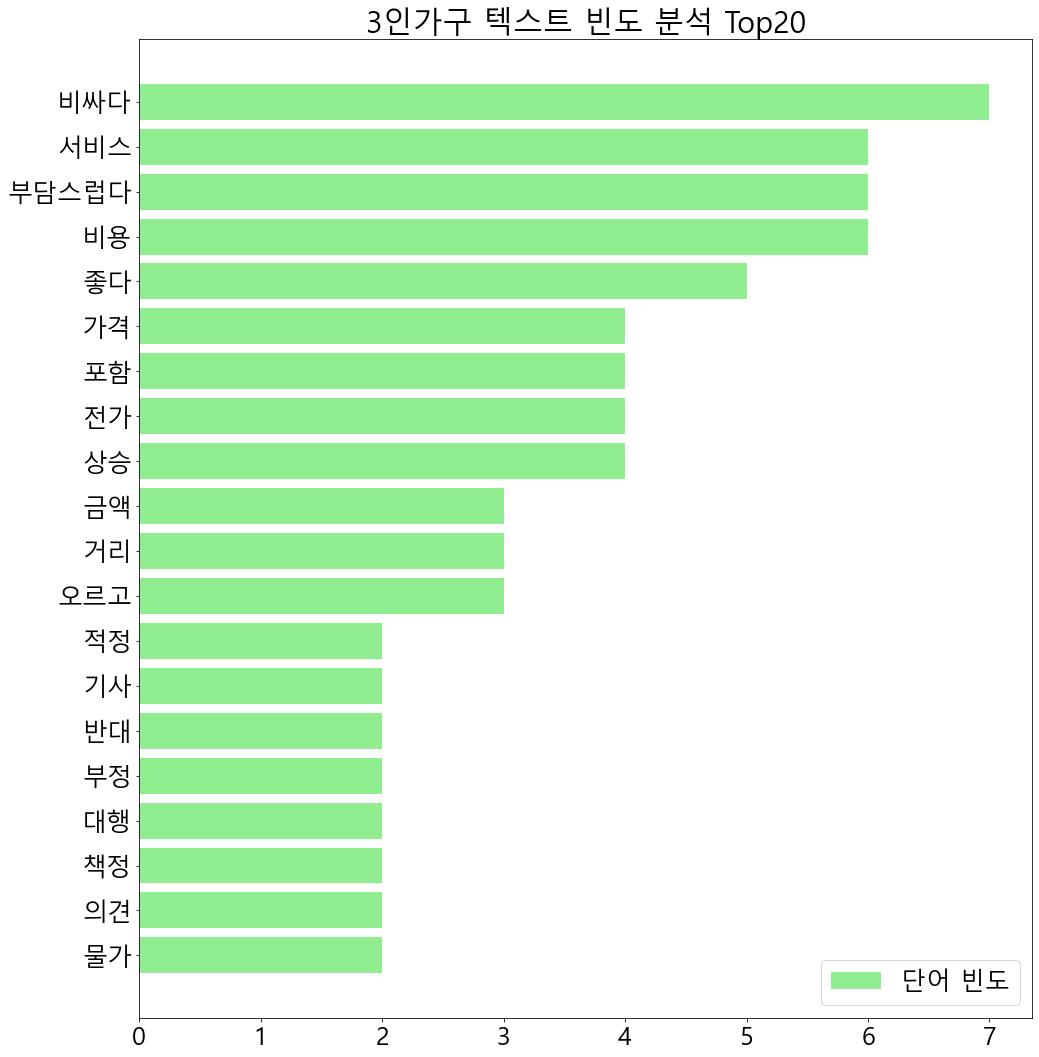

In [226]:
# 3인가구
family3_word, family3_vector = count_vector(family3, count_vec)
count_graph(family3_word, family3_vector,'lightgreen', '3인가구')

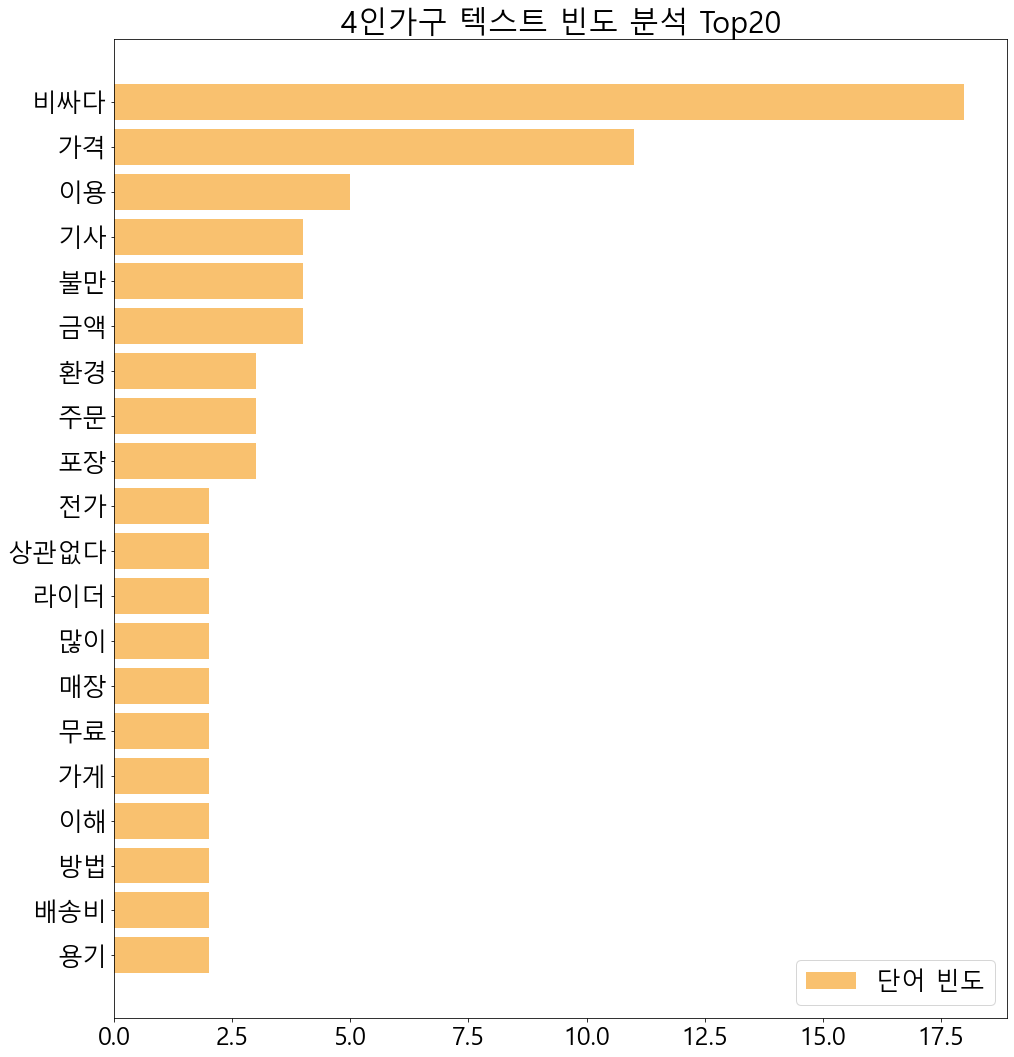

In [233]:
# 4인가구
family4_word, family4_vector = count_vector(family4, count_vec)
count_graph(family4_word, family4_vector,'#F9C16F', '4인가구')

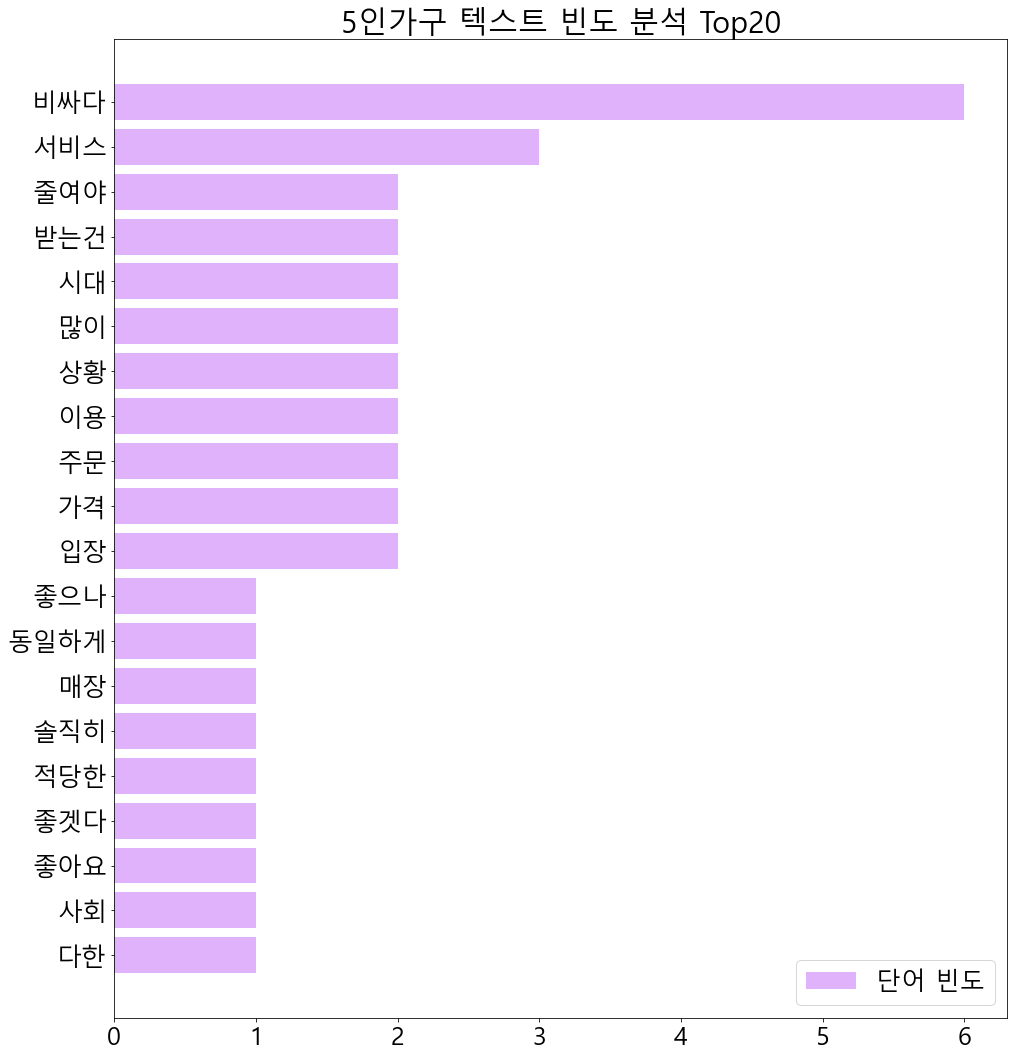

In [234]:
# 5인가구
family5_word, family5_vector = count_vector(family5, count_vec)
count_graph(family5_word, family5_vector,'#E0B2FC', '5인가구')